In [42]:
using BenchmarkTools

include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

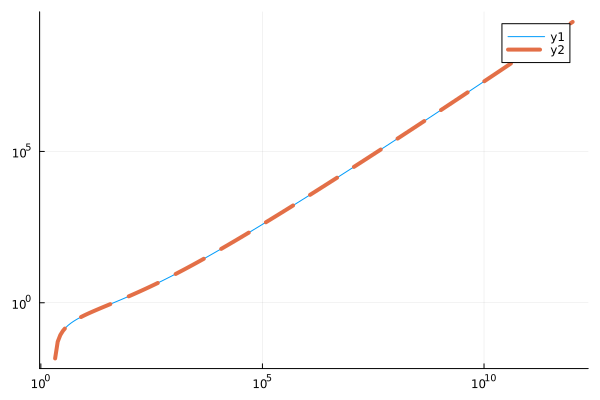

In [93]:
using Plots

Mhost_init = 1e+12
Mres = 1e+0

Mhost = 10.0.^range(log10(2.1*Mres), log10(Mhost_init), 200)

function_P, function_F = cj.interpolate_functions_PF(Mhost_init, Mres)

plot(Mhost, cj.mean_number_progenitors.(Mhost/2.0, Mhost, Mres), xscale=:log10,  linestyle=:solid, yscale=:log10)
plot!(Mhost, function_P.(Mhost, Mres), xscale=:log10, linestyle=:dash, linewidth=4, yscale=:log10)

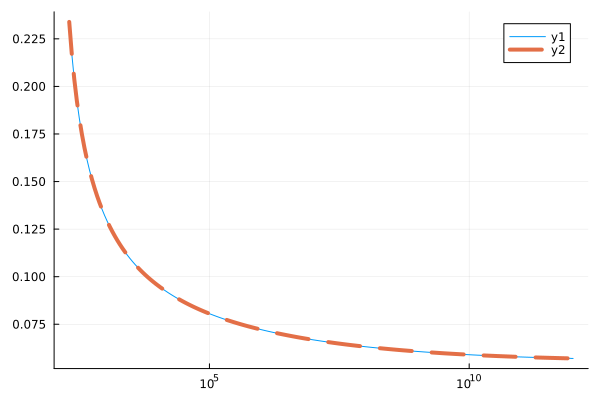

In [94]:
using Plots

Mhost_init = 1e+12
Mres = 1e+2

Mhost = 10.0.^range(log10(2*Mres), log10(Mhost_init), 200)

function_P, function_F = cj.interpolate_functions_PF(Mhost_init, Mres)

plot(Mhost, cj.mass_fraction_unresolved.(Mhost, Mres), xscale=:log10,  linestyle=:solid)
plot!(Mhost, function_F.(Mhost), xscale=:log10, linestyle=:dash, linewidth=4)

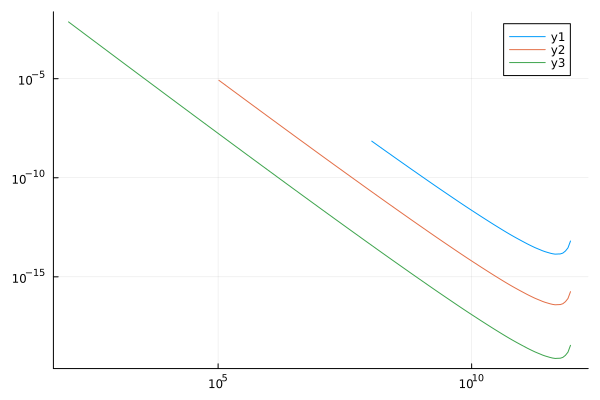

In [95]:
using Plots

M1   = 1e+12
M2 = 10.0.^range(2, log10(M1), 200)

plot(M2[M2.>1e+8], cj.pdf_progenitors.(M2[M2.>1e+8], M1, 1e+8), xscale=:log10, yscale=:log10)
plot!(M2[M2.>1e+5], cj.pdf_progenitors.(M2[M2.>1e+5], M1, 1e+5), xscale=:log10, yscale=:log10)
plot!(M2[M2.>1e+2], cj.pdf_progenitors.(M2[M2.>1e+2], M1, 1e+2), xscale=:log10, yscale=:log10)

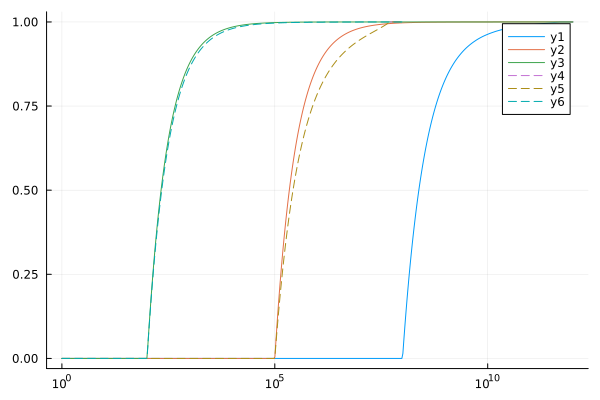

In [88]:
using Plots

M1   = 1e+12
M2 = 10.0.^range(0, log10(M1), 500)

plot(M2, cj.cumulative_progenitors.(M2, M1, 1e+8), xscale=:log10)
plot!(M2, cj.cumulative_progenitors.(M2, M1, 1e+5), xscale=:log10)
plot!(M2, cj.cumulative_progenitors.(M2, M1, 1e+2), xscale=:log10)

M1   = 1e+8
M2 = 10.0.^range(0, log10(M1), 500)

plot!(M2, cj.cumulative_progenitors.(M2, M1, 1e+8), xscale=:log10, linestyle=:dash)
plot!(M2, cj.cumulative_progenitors.(M2, M1, 1e+5), xscale=:log10, linestyle=:dash)
plot!(M2, cj.cumulative_progenitors.(M2, M1, 1e+2), xscale=:log10, linestyle=:dash)

In [46]:
subhalo_mass1, m_host1, z_steps1, _ = cj.subhalo_mass_function(1e+12, 1e+8)
subhalo_mass2, m_host2, z_steps2, _ = cj.subhalo_mass_function(1e+12, 1e+7)
#subhalo_mass3, m_host3, z_steps3, _ = cj.subhalo_mass_function(1e+12, 1e+5)

0.2957417459915064 32 0.7571087654120459 0.1


0.610921672270706 73 0.7006032279052674 0.1


0.9460648735353061 112 0.5609336691726582 0.1


1.3649841148981068 145 0.42408627662869125 0.1


1.845011999973849 188 0.3156161415981605 0.1


2.5998598883552404 226 0.15949994689086527 0.1


4.015694634314968 268 0.07225343002258955 0.1


7.878246206904805 313 0.004095039581510832 0.1


0.3218551185776164 276 0.5476447973368948 0.1


0.8162331760966026 521 0.40053010310638365 0.1


1.3588519311558684 759 0.32213075064359503 0.1


2.0494416041096883 1028 0.23774510833107862 0.1


2.9102320777992645 1285 0.17448081243929997 0.1


5.321342775759149 1567 0.02397348791606551 0.1


([3.556036635779649e-5, 7.946681405276495e-5, 2.4017047464533206e-5, 3.521825905154368e-5, 1.083381612813268e-5, 4.728839996041676e-5, 0.00010191869806660269, 6.967481789305773e-5, 1.8349871568649385e-5, 4.616331220207164e-5  …  1.6448637843910914e-5, 3.521187908132004e-5, 0.00013069411003042652, 1.5224472959136636e-5, 0.00017982988581709072, 3.171175938646838e-5, 1.9164057176101423e-5, 1.1828223220044395e-5, 1.1421506925501922e-5, 1.9176454110049132e-5], [5.476555746410077e11, 4.005406851622886e11, 3.221411968506202e11, 2.3775535003828143e11, 1.7450719338191327e11, 2.3981731706995224e10], [0.3218551185776164, 0.8162331760966026, 1.3588519311558684, 2.0494416041096883, 2.9102320777992645, 5.321342775759149], [0.0022301734163190368, 0.0024647197888691963, 0.004222641849716879, 0.006913736596587228, 0.00738122303201294, 0.0084324912721776, 0.008666006669532322, 0.010066394689481228, 0.010416290825023822, 0.010766103817879014  …  11.497950026803709, 11.694991692828095, 11.783732545365472,

In [ ]:
subhalo_mass = cj.subhalo_mass_function_array(1e+12, 1e+8)
#@benchmark cj.one_step_merger_tree([0.1, 0.8], [0.01, 0.01], [1e+10, 1e+10], 1e+8, cj.planck18, x->x^2)
#@benchmark cj.one_step_merger_tree(0.1, 0.01, 1e+10, 1e+8)

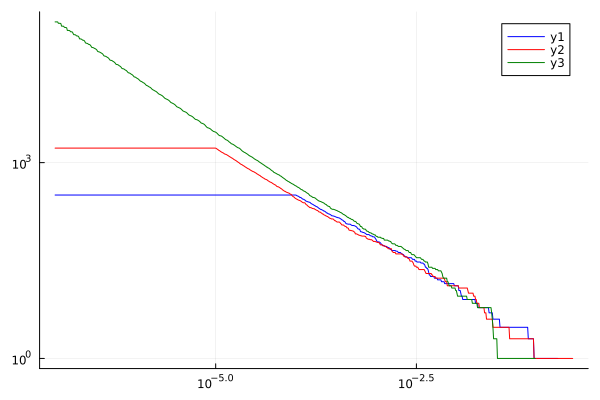

In [58]:
using Plots

m_array = 10.0.^range(-7, stop=1, length=1000)
CMF1 = [count(x -> x > m, subhalo_mass1) for m in m_array]
CMF2 = [count(x -> x > m, subhalo_mass2) for m in m_array]
CMF3 = [count(x -> x > m, subhalo_mass3) for m in m_array]

plot(m_array[CMF1 .> 0], CMF1[CMF1 .> 0], xscale=:log10, yscale=:log10, color=:blue)
plot!(m_array[CMF2 .> 0], CMF2[CMF2 .> 0], xscale=:log10, yscale=:log10, color=:red)
plot!(m_array[CMF3 .> 0], CMF3[CMF3 .> 0], xscale=:log10, yscale=:log10, color=:green)

In [178]:
using SpecialFunctions
using LsqFit

function fitting_function(m_m0, γ1, α1, α2, β, ζ)
    if α1 > 2 || α1 < 1 || α2 > 2 || α2 < 1 || β < 0 || ζ < 0 || γ1 < 0
        return Inf
    end
    int1 =  β.^(.-(2.0.-α1)./ζ) .* gamma.((2.0.-α1)./ζ) .*  gamma_inc.((2.0.-α1)./ζ, β)[1] ./ ζ 
    int2 =  β.^(.-(2.0.-α2)./ζ) .* gamma.((2.0.-α2)./ζ) .*  gamma_inc.((2.0.-α2)./ζ, β)[1] ./ ζ 
    γ2 = (1.0 .- γ1 .* int1) ./  int2
    return γ1./ζ .* ((m_m0).^(1.0.-α1) .* expint.((α1.-1.0)./ζ .+ 1.0, β.*(m_m0).^ζ) .- expint.((α1.-1.0)./ζ .+ 1.0, β)) .+  γ2./ζ .* ((m_m0).^(1.0.-α2) .* expint.((α2.-1.0)./ζ .+ 1.0, β.*(m_m0).^ζ) .- expint.((α2.-1.0)./ζ .+ 1.0, β)) 
end

p0 = [0.019, 1.94, 1.58, 24, 3.4]

model(t, p) = @. log10.(fitting_function(10.0.^t, p[1], p[2], p[3], p[4], p[5]))

fit = curve_fit(model, log10.(m_array[CMF3 .> 0]), log10.(CMF3[CMF3 .> 0]), p0)

println(fit.param)

res = 10.0.^model(log10.(m_array), fit.param) #fitting_function(1e+12 .* m_array, 1e+12, fit.param...)
plot(m_array[res .> 0], res[res .> 0], xscale=:log10, yscale=:log10, ylim=[1e-1, 1e+5])
plot!(m_array[CMF3 .> 0], CMF3[CMF3 .> 0], xscale=:log10, yscale=:log10, ylim=[1e-1, 1e+5])


[0.051814451871656474, 1.9239184528109405, 1.3102031446473947, 7.570981401648537, 0.3772522197544308]


DomainError: DomainError with -7.772157589905836e-5:
log10 will only return a complex result if called with a complex argument. Try log10(Complex(x)).

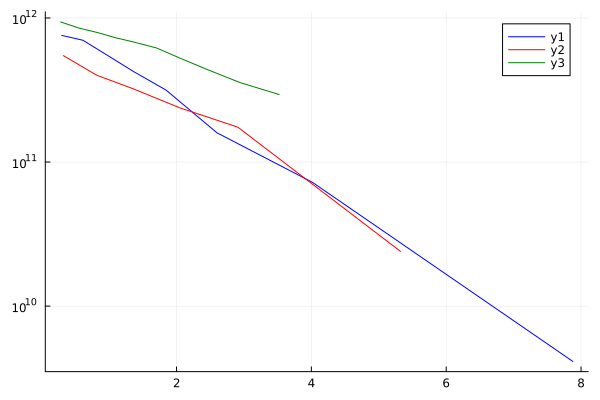

In [48]:
plot(z_steps1, m_host1, yscale=:log10, color=:blue)
plot!(z_steps2, m_host2, yscale=:log10, color=:red)
plot!(z_steps3, m_host3, yscale=:log10, color=:green)

In [13]:
m_host1

Float64[]

In [11]:
using StatsBase
using Plots

result = fit(Histogram, log10.(subhalo_mass), nbins=50)
result = 
println(size(result.edges[1]), size(result.weights))

plot(result.edges[1][2:end], log10.(result.weights), st=:stairs)

UndefVarError: UndefVarError: subhalo_mass not defined

In [51]:
function one_step_merger_tree(P::Vector{<:Real}, F::Vector{<:Real}, M1::Vector{<:Real}, Mres::Real)

    n = length(M1)
    _R = rand(Float64, n)

    M2 = zeros(n)
    array_progenitors = zeros(n, 2)

    id_tree_0 = ((P .< _R) .| (M1 .< 2 * Mres)  .&  (M1 .* (1.0 .-F) .> Mres)) 
    array_progenitors[id_tree_0, 1] =  M1[id_tree_0] .* (1.0 .- F[id_tree_0])

    id_tree_1 = ((P .> _R) .& (M1 .> 2 * Mres))

    #_random = rand(Float64, sum(id_tree_1))
    #M2[id_tree_1] = draw_mass_with_restrictions.(_random, M1[id_tree_1], Mres, itp_functionP, cosmology = cosmology)
    #array_progenitors[id_tree_1, 2] =  M2[id_tree_1]
    #id_tree_2 = (id_tree_1 .& (M1 .* (1.0 .- F) .- M2 .> Mres))
    #array_progenitors[id_tree_2, 1] =  M1[id_tree_2] .* (1.0 .- F[id_tree_2]) .- M2[id_tree_2]

    #return array_progenitors
end

@benchmark one_step_merger_tree([0.1, 0.8], [0.01, 0.01], [1e+10, 1e+10], 1e+8)

BenchmarkTools.Trial: 10000 samples with 202 evaluations.
 Range (min … max):  401.609 ns … 56.302 μs  ┊ GC (min … max):  0.00% … 98.98%
 Time  (median):     415.842 ns              ┊ GC (median):     0.00%
 Time  (mean ± σ):   511.004 ns ±  2.107 μs  ┊ GC (mean ± σ):  16.46% ±  3.96%

   ▅█▁                                                          
  ▃███▅▆▇▆▄▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  402 ns          Histogram: frequency by time          601 ns <

 Memory estimate: 884 bytes, allocs estimate: 13.

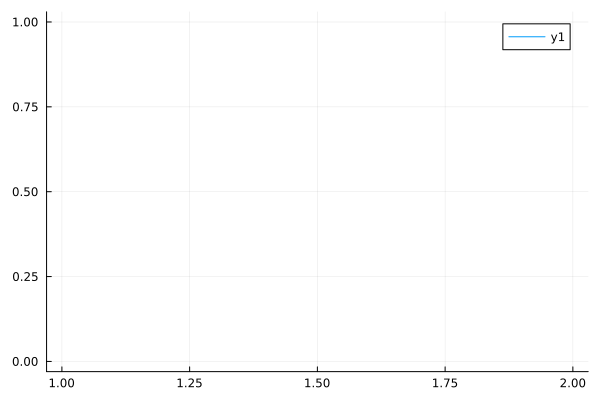

In [35]:
using Plots

histogram(rand(10000000), bins=0.999999798712612:0.1*0.999999798712612:1)

In [88]:
cj.cumulative_progenitors.(4.99167097900047e11, 9.983341958000925e11, 1e+6)

1.0